In [1]:
import os
from trainy_context import train
import toy
import numpy as np
import datetime
from model import VAE_Solver,RL_Solver
from toy import ContextProblem
import torch
import loss_functions

/home/mvmacfarlane/miniconda3/envs/CVAE_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


In [3]:
#Create config

config = Namespace(

    #Running Settings
    output_path = "",
    device = "cuda",
    model_path = None,

    #Training
    batch_size = 512,
    epoch_size = 512*8,  #102400
    generate_solutions_batch_size = 512*8,
    nb_epochs = 200 ,
    lr = 1e-3, #1e-4
    lr_imp = 1e-3,
    lr_diff = 1e-3,

    #Loss
    KLD_weight = 1e-3, #0.001

    #Problem Statement
    variation = True,
    problem = "smooth_1",  #Not relevant anymore

    #VAE training
    weighting = True,
    weighting_temp = 1,
    sample_num = 4,  #To estimate advantage

    #Problem sampling
    sample_uniform = True,

    #Decoding Method
    testing_decoding_greedy = True,  #Need to specify all the different decoding decisions

    #Diffusion
    diffusion_steps = 100,
    diffusion_loops = 1,

    #Evaluation search budget
    test_retry_num = 1,
    evaluation_num = 512, #512*8*4

    num_var = 2,
    deg = 2,

    latent_size = 2,   #We should make this larger

    act_type = "Relu",  #Relu

    embed_dim = 128,


)


In [4]:

exp_name = "old_generator_added_time"
#exp_name = "problems:1_baseline:4_uniform:5_epochs"


config.exp_name = exp_name
run_id = np.random.randint(10000, 99999)
now = datetime.datetime.now()

if config.output_path == "":
    config.output_path = os.getcwd()
    config.output_path_fixed = config.output_path
    config.output_path = os.path.join(config.output_path,"experiment_info", config.exp_name + ":_" + str(now.day) + "." + str(now.month) +"." + str(now.year) + "_" + str(run_id))

    os.makedirs(os.path.join(config.output_path, "models"))
    os.makedirs(os.path.join(config.output_path, "latent_images"))

In [5]:


model = VAE_Solver(
    
    config,

    diffusion_steps = config.diffusion_steps,
    num_var = config.num_var,
    deg = config.deg,
    latent_size = config.latent_size,
    act_type = config.act_type,
    embed_dim = config.embed_dim,
    

).to(config.device)

problem = ContextProblem(testing_num = config.evaluation_num ,variation = config.variation,num_var = config.num_var,deg = config.deg)


Finding Optimal Solutions


100%|██████████| 512/512 [00:01<00:00, 344.46it/s]


In [6]:
def sample(model, size):

    latent_sample = model.diffusion.generate_sample_good(testing_num,None,advantage = None,device = config.device).detach()

    return None

    

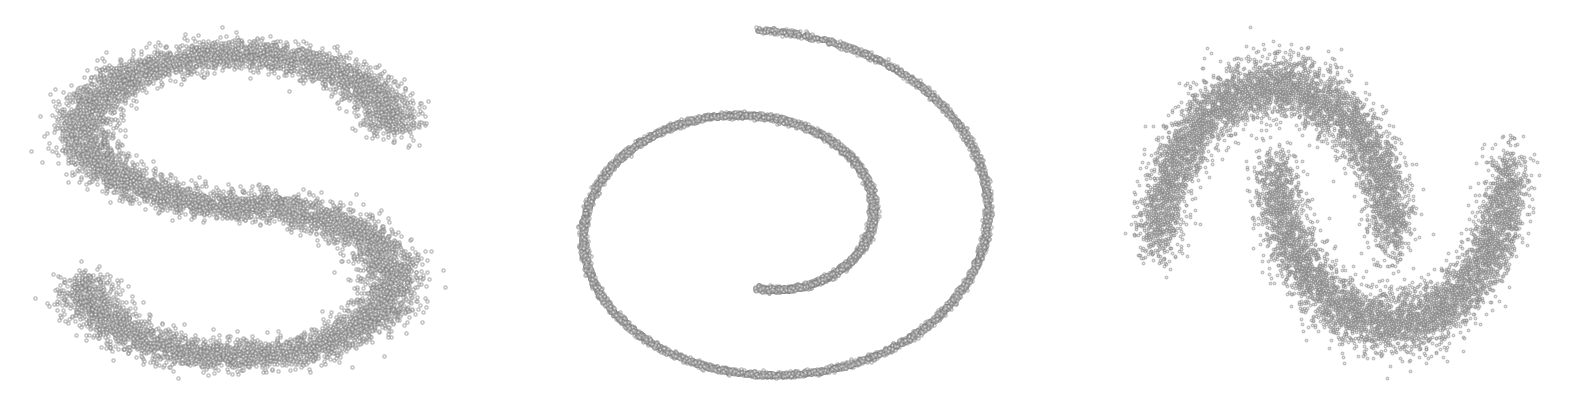

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
from helper_plot import hdr_plot_style
import torch
from utils import * 

#hdr_plot_style()
swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]/10.0

s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

moons, _ = make_moons(10**4, noise=0.1)

data = s_curve.T
#dataset = torch.Tensor(data.T).float()


fig,axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[0].axis('off')

data = swiss_roll.T
axes[1].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[1].axis('off')
#dataset = torch.Tensor(data.T).float()

data = moons.T
axes[2].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=3);
axes[2].axis('off')


dataset = torch.Tensor(swiss_roll.T.T).float()

Diff loss:0.6788535714149475
Value loss:0.0010361287277191877


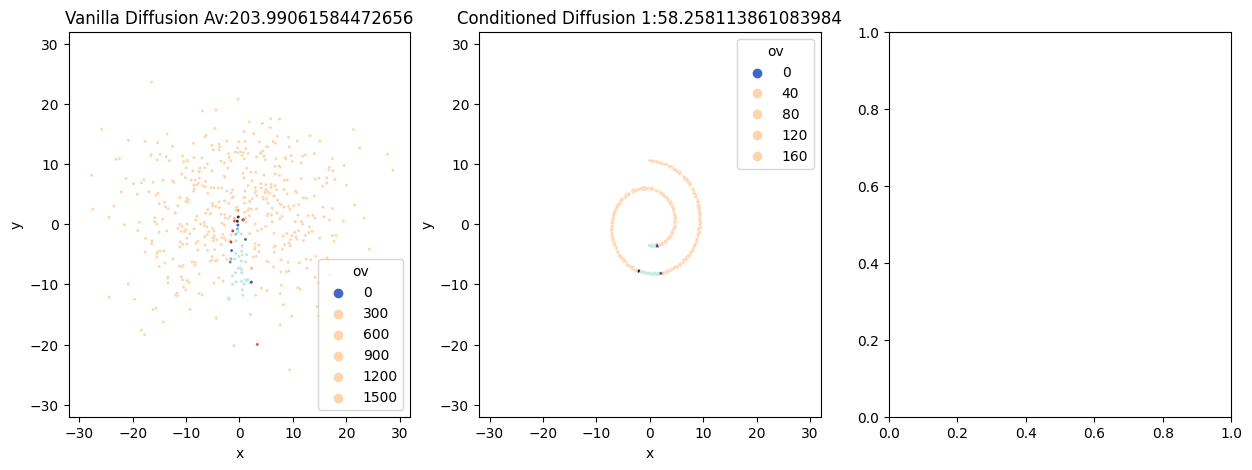

Diff loss:0.3819091022014618
Value loss:2.143818619515514e-06


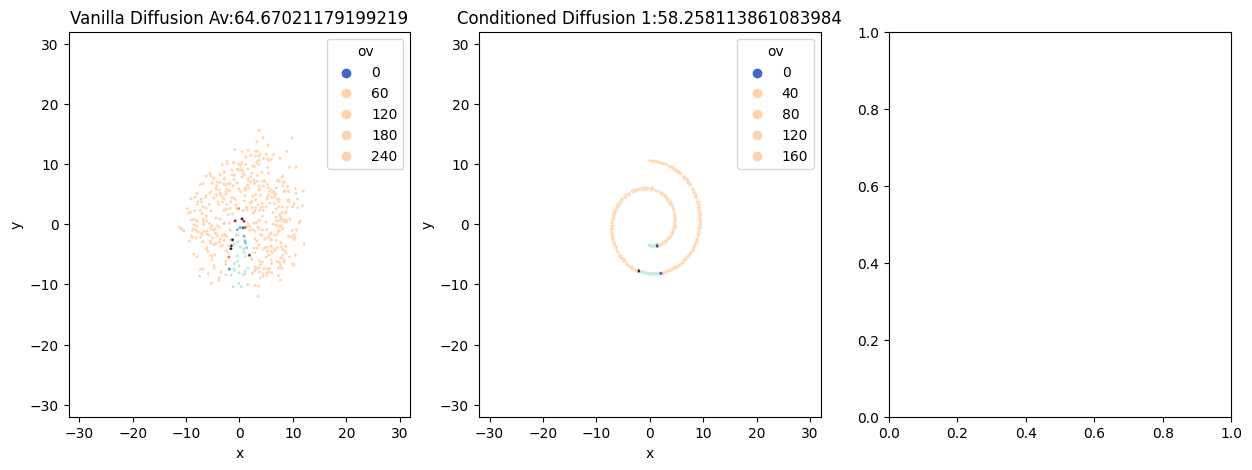

Diff loss:0.672268807888031
Value loss:1.7633039988140808e-06


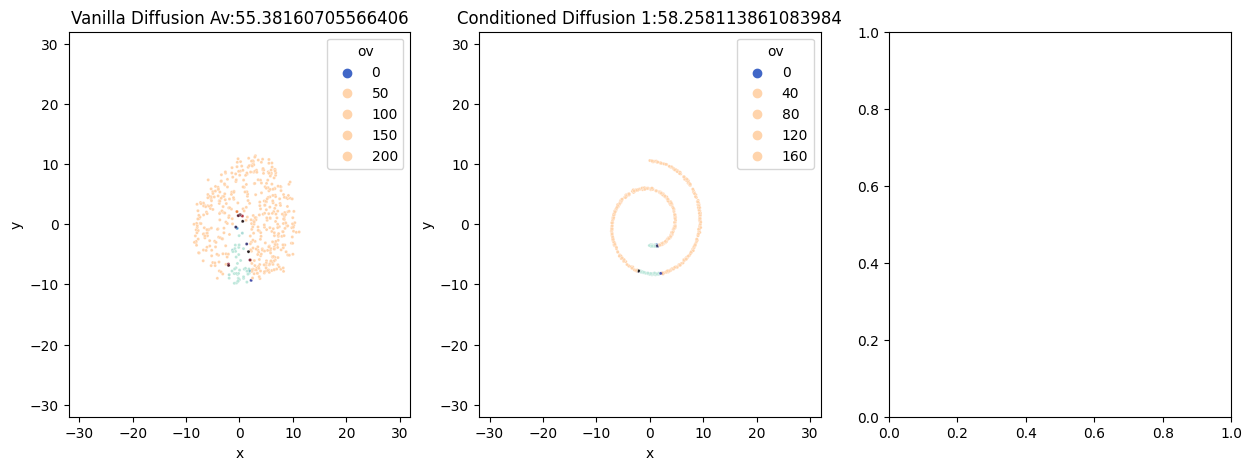

Diff loss:0.6132463216781616
Value loss:1.754254981278791e-06


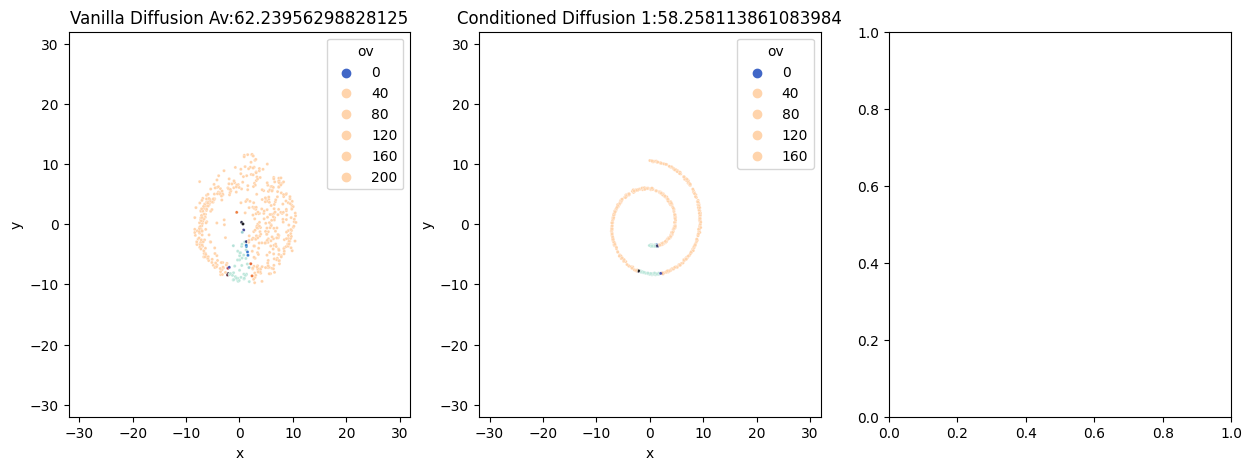

Diff loss:0.4900282025337219
Value loss:1.6247404346358962e-06


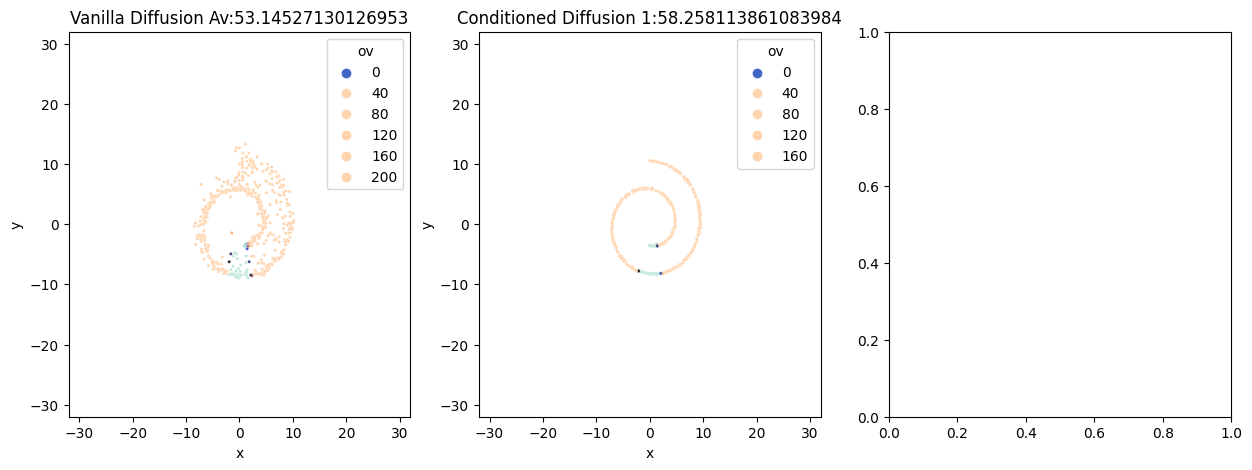

Diff loss:0.3129963278770447
Value loss:3.483791033431771e-07


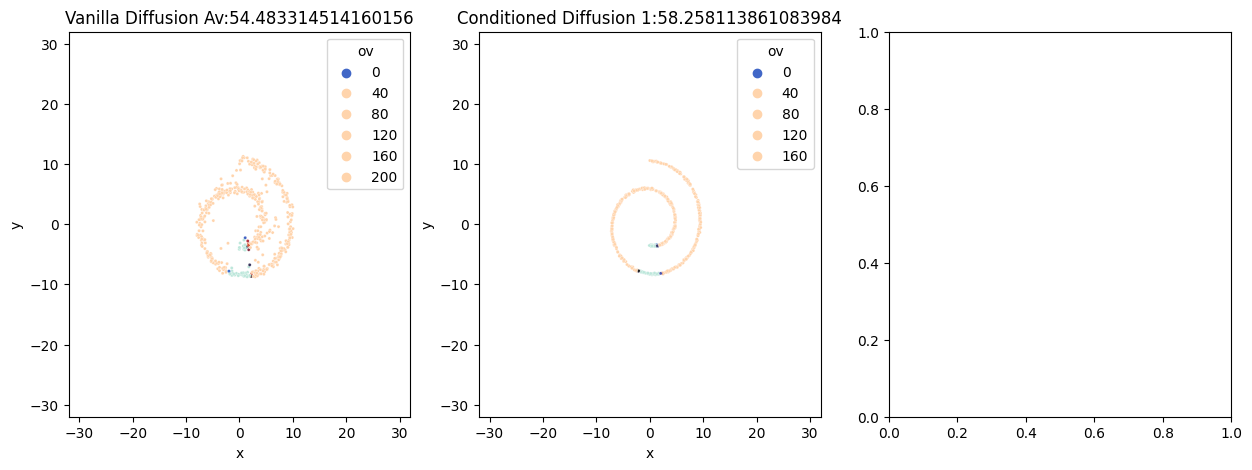

Diff loss:0.3867529630661011
Value loss:3.0922005862521473e-06


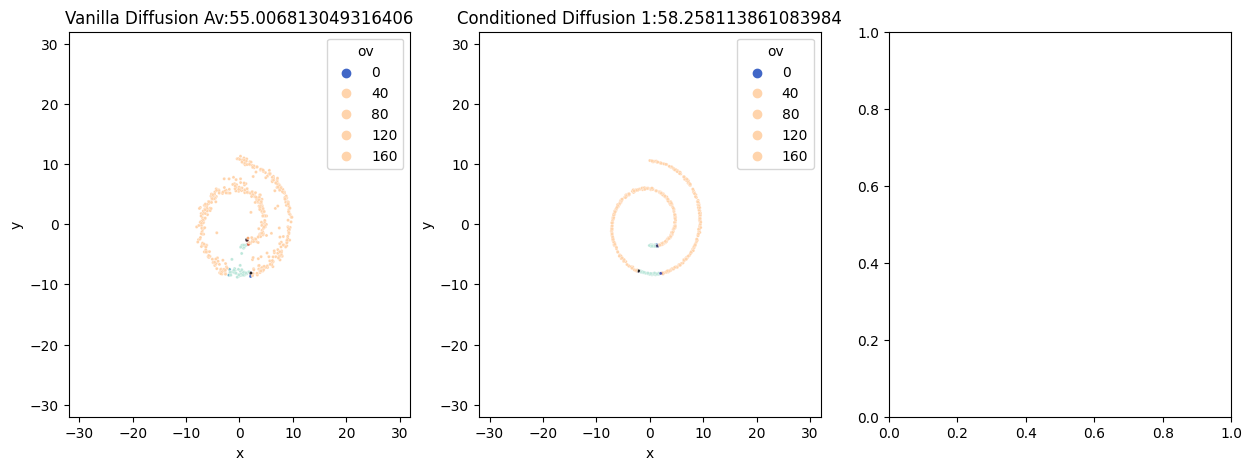

Diff loss:0.3967812657356262
Value loss:3.7616184727085056e-06


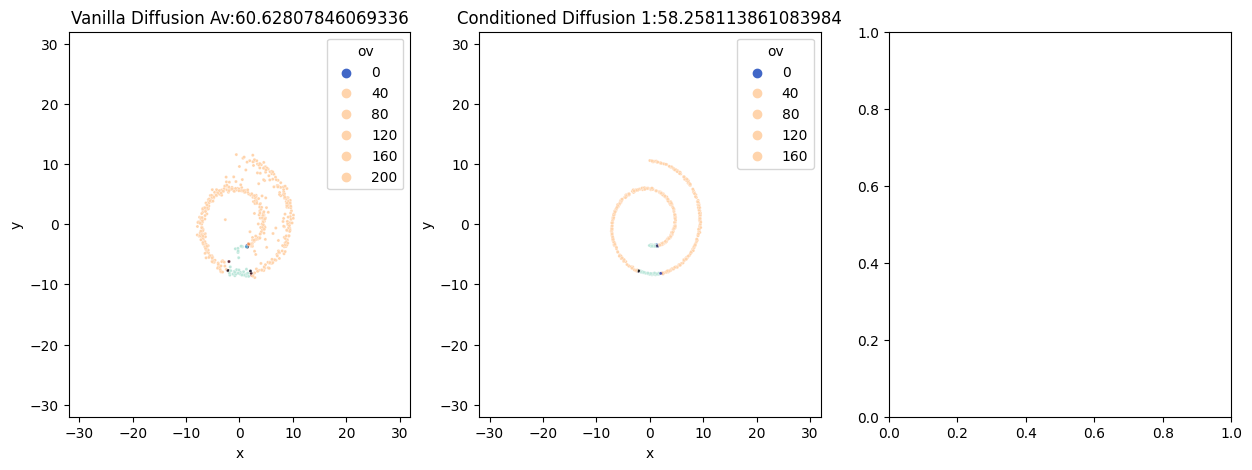

In [8]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)

problem.generate_new_problems(
            size = config.epoch_size,
)

# Batch size
# Try using a the batch of 512 and see what happens
batch_size = 128

scale = 7.5

dataset = dataset*scale

maxy = torch.max(dataset)
miny = torch.min(dataset)


for t in range(10000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])



    epoch_loss= 0


    

    #dataset = 2*(dataset - miny)/(maxy-miny) - 1

    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]

        batch_x = 2*(batch_x- miny)/(maxy-miny) - 1
        #batch_x = dataset[indices]*16


        # Compute the loss.
        #loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)



        batch_x = batch_x.to(config.device)


        #batch_x = (batch_x - torch.min(batch_x))/((torch.max(batch_x) - torch.min(batch_x)))

        contexts = problem.get_context()[0:batch_x.shape[0],:]


        reward  = problem.cost_func(solution = batch_x,context = contexts).unsqueeze(dim=1)

        


        value_pred = model.diffusion.improver.predict_value(batch_x)



        loss_V = loss_functions.calculate_value_pred_loss(

                pred = value_pred,
                target = reward,

        )

        loss = model.diffusion.calculate_loss(
                
                x0 = batch_x,
                context = batch_x,
                advantage = batch_x,
                
        )

        loss_total = loss_V + loss

        epoch_loss += loss*batch_x.shape[0]


        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss_total.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average

    #Collect a total loss for whole dataset

    eval_num = 512

    # Print loss
    if (t % 100 == 0):
        print("Diff loss:{}".format(epoch_loss/dataset.size()[0]))
        #print("Value loss:{}".format(loss_V))


        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        #for i in range(1, 11):
        cur_x = model.diffusion.generate_sample_good(eval_num,batch_x,advantage = batch_x,device = config.device,gradient = None).detach().cpu()
        cur_x = (((cur_x + 1)/2)*((maxy-miny))) + miny

        #dataset = 2*(dataset - miny)/(maxy-miny) - 1


        #cur_x_2 = model.diffusion.generate_sample_good(eval_num,batch_x,advantage = batch_x,device = config.device,gradient = 1).detach().cpu()
        #cur_x_3 = model.diffusion.generate_sample_good(eval_num,batch_x,advantage = batch_x,device = config.device,gradient = 5).detach().cpu()
        true_sample = dataset[0:eval_num]


        problem.generate_new_problems(
            size = config.epoch_size,
        )

        contexts = problem.get_context()[0:eval_num,:]

        for i,data1 in enumerate([cur_x,true_sample]):

            reward  = problem.cost_func(solution = data1,context = contexts)

            average_reward = torch.mean(reward).item()


            data = pd.DataFrame(torch.cat((data1,reward.unsqueeze(dim=1)),dim = 1).detach().numpy(),columns = ['x','y','ov'])


            #axs.scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5)
            sns.scatterplot(data=data , x="x", y="y", hue="ov",hue_norm = (-1,3),palette = "icefire",s=5,ax= axs[i])

            #axs[i].set_axis_off(); 

            if i == 0:
                axs[i].set_title('Vanilla Diffusion Av:{}'.format(average_reward))

                axs[i].set_ylim(-32,32)
                axs[i].set_xlim(-32,32)


            elif i == 1:
                axs[i].set_title('Conditioned Diffusion 1:{}'.format(average_reward))

                axs[i].set_ylim(-32,32)
                axs[i].set_xlim(-32,32)
            elif i == 2:
                axs[i].set_title('Conditioned Diffusion 5:{}'.format(average_reward))

            




        
        plt.show()
        
        
    